**Grupo:** Arthur Wachslicht e Pedro Osorio

![title](https://www.educafro.org.br/site/wp-content/uploads/2020/10/faculdade-insper-logo.png)

### Importando os módulos necessários:

In [143]:
import pandas as pd 
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as dt
%matplotlib inline

### Importanto e montando as bases necessárias:

In [144]:
# Defino o dataframe de dados de preço dos ativos do portfólio: 
precos = pd.DataFrame() 

# Defino os quais os ativos que vamos utilizar:
assets = ['ABEV3.SA','LREN3.SA','PETR4.SA','VALE3.SA','PSSA3.SA','POMO4.SA','LAME4.SA','MRFG3.SA','BBAS3.SA','ITUB4.SA']

# Importo os dados de preço do yahoo finance:
for i in assets: 
    precos[i]=dt.DataReader(i,data_source='yahoo',start='2010-01-01')['Adj Close']
    
precos.dropna(inplace=True)    

# Defino o dataframe de retornos diários de cada ativo:
retornos = precos.pct_change()

### Plotando cada o resultado de cada ativo:

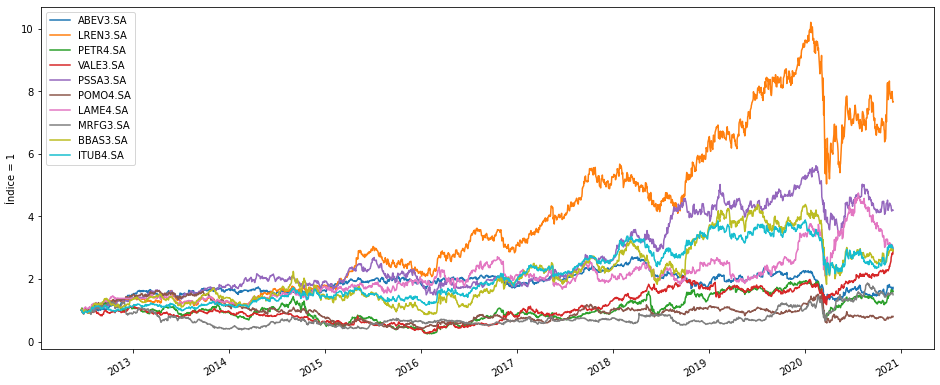

In [180]:
(precos.loc[precos.index.sort_values()]/precos.loc[precos.index.sort_values()].iloc[0]).plot(figsize=(16,7))
plt.ylabel("Índice = 1");

### Definindo a taxa livre de risco que utilizaremos:

In [181]:
rf = (1 + 0.02)**(1/252)-1

### Fazendo uma matriz de correlação entre os ativos:

In [182]:
matriz_correlacao = retornos.corr()
matriz_correlacao

,ABEV3.SA,LREN3.SA,PETR4.SA,VALE3.SA,PSSA3.SA,POMO4.SA,LAME4.SA,MRFG3.SA,BBAS3.SA,ITUB4.SA
ABEV3.SA,1.000000,0.430035,0.359798,0.269395,0.276924,0.315334,0.420732,0.259153,0.387066,0.454706
LREN3.SA,0.430035,1.000000,0.462959,0.290778,0.347432,0.408492,0.575372,0.303940,0.542921,0.556724
PETR4.SA,0.359798,0.462959,1.000000,0.488300,0.292724,0.351071,0.464657,0.383470,0.638852,0.600893
VALE3.SA,0.269395,0.290778,0.488300,1.000000,0.180672,0.215211,0.302453,0.283771,0.362456,0.364930
PSSA3.SA,0.276924,0.347432,0.292724,0.180672,1.000000,0.221401,0.322321,0.159805,0.373233,0.386311
POMO4.SA,0.315334,0.408492,0.351071,0.215211,0.221401,1.000000,0.406790,0.239974,0.411646,0.415844
LAME4.SA,0.420732,0.575372,0.464657,0.302453,0.322321,0.406790,1.000000,0.358311,0.523125,0.510567
MRFG3.SA,0.259153,0.303940,0.383470,0.283771,0.159805,0.239974,0.358311,1.000000,0.323268,0.295197
BBAS3.SA,0.387066,0.542921,0.638852,0.362456,0.373233,0.411646,0.523125,0.323268,1.000000,0.758551
ITUB4.SA,0.454706,0.556724,0.600893,0.364930,0.386311,0.415844,0.510567,0.295197,0.758551,1.000000


### Pegando a média de retornos de cada ativos:

In [183]:
media_retornos = retornos.mean()
media_retornos

ABEV3.SA    0.000407
LREN3.SA    0.001237
PETR4.SA    0.000751
VALE3.SA    0.000927
PSSA3.SA    0.000880
POMO4.SA    0.000281
LAME4.SA    0.000799
MRFG3.SA    0.000661
BBAS3.SA    0.000920
ITUB4.SA    0.000735
dtype: float64

### Definindo o número de retornos que utilizaremos na otimização:

In [184]:
retornos_vetor = np.linspace(min(media_retornos),max(media_retornos),2000)

### Função para volatilidade do portfólio:

In [185]:
def volatilidade(pesos):
    pesos = np.array(pesos)
    covar = np.array(retornos.cov())
    vol = np.dot(pesos.T, np.dot(covar, pesos)) 
    return np.sqrt(vol)

### Função para o retornos do portfólio:

In [186]:
def returns(pesos):
    return np.dot(np.array(pesos),np.array(media_retornos)).sum()

### Função para checar se os pesos somam 1:

In [187]:
def checasoma(pesos):
    return np.sum(pesos)-1

### Chute inicial para a minimização:

In [188]:
chute = [0.00025 for i in range(10)]

### Definindo o intervalo em que os pesos podem variar:

In [189]:
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

### Fazendo a minimização:

In [190]:
fronteira = []
fronteira_pesos = []
for retorno_possivel in retornos_vetor:
    cons = ({"type":"eq","fun":checasoma},
           {"type":"eq","fun":lambda n:returns(n)-retorno_possivel})
    resultado = opt.minimize(volatilidade,chute,method = "SLSQP",bounds = bounds, constraints=cons)
    fronteira.append(resultado["fun"])
    fronteira_pesos.append(resultado["x"])

### Encontrando o portfólio de mínima variância na fronteira otimizada:

In [191]:
min_var = min(fronteira)
retorno_min_var = retornos_vetor[fronteira.index(min(fronteira))]

### Simulando vários portfólios:

In [192]:
ret = []
vol=[]
for i in range(2000000):
    weights = np.random.rand(10)
    weights /= weights.sum()
    vol.append(volatilidade(weights))
    ret.append(returns(weights))

### Calculando o sharpe de cada portfólio simulado:

In [193]:
sharpe_fronteira = (retornos_vetor-rf)/fronteira

### Encontrando o retorno e o risco do portfólio de maior sharpe na fronteira otimizada:

In [194]:
sharpe_max_vol = fronteira[np.argmax(sharpe_fronteira)]
sharpe_max_retorno = retornos_vetor[np.argmax(sharpe_fronteira)]

### Plotando apenas os resultados dos portfólios simulados:

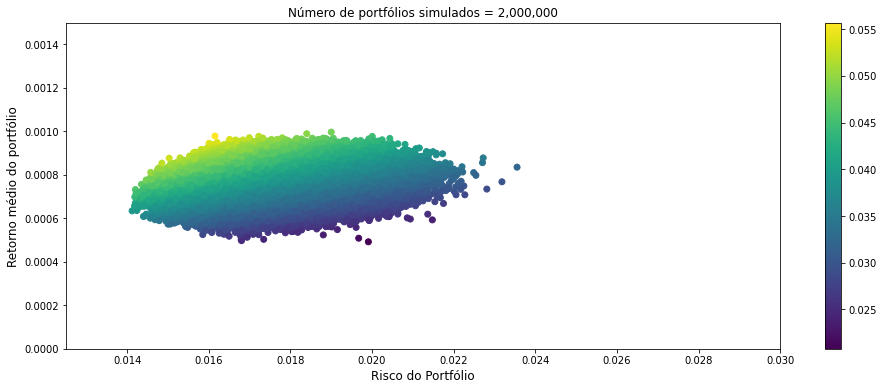

In [217]:
sharpe = (np.array(ret)-rf)/np.array(vol)
plt.figure(figsize=(16,6))
plt.scatter(vol,ret,c=sharpe,cmap="viridis")
plt.xlabel("Risco do Portfólio",fontsize=12)
plt.ylabel("Retorno médio do portfólio",fontsize=12)
plt.title("Número de portfólios simulados = 2,000,000")
plt.axis([0.0125,0.03,0,0.0015])
colorbar=plt.colorbar()
colorbar.ax.set_label("Sharpe")
plt.show()

### Plotando apenas a fronteira otimizada:

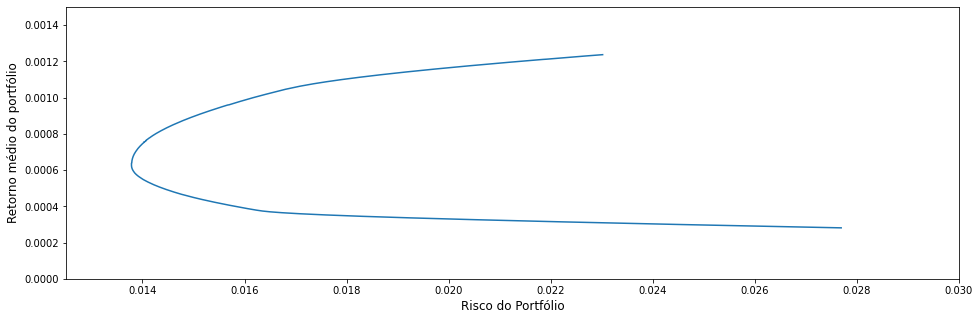

In [218]:
plt.figure(figsize=(16,5))
plt.plot(fronteira,retornos_vetor)
plt.xlabel("Risco do Portfólio",fontsize=12)
plt.ylabel("Retorno médio do portfólio",fontsize=12)
plt.axis([0.0125,0.03,0,0.0015])
plt.show()

### Plotando os portfólios simulados junto com a fronteira simulada

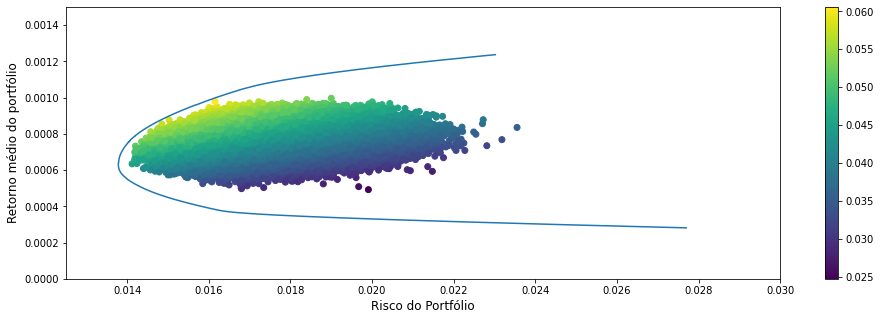

In [219]:
sharpe = (np.array(ret))/np.array(vol)
plt.figure(figsize=(16,5))
plt.scatter(vol,ret,c=sharpe,cmap="viridis")
plt.plot(fronteira,retornos_vetor,label="Fronteira por otimização")
plt.xlabel("Risco do Portfólio",fontsize=12)
plt.ylabel("Retorno médio do portfólio",fontsize=12)
plt.axis([0.0125,0.03,0,0.0015])
plt.colorbar()
plt.show()

### Plotando a fronteira com as simulações com o portfolio de minima variancia e o de máximo sharpe:

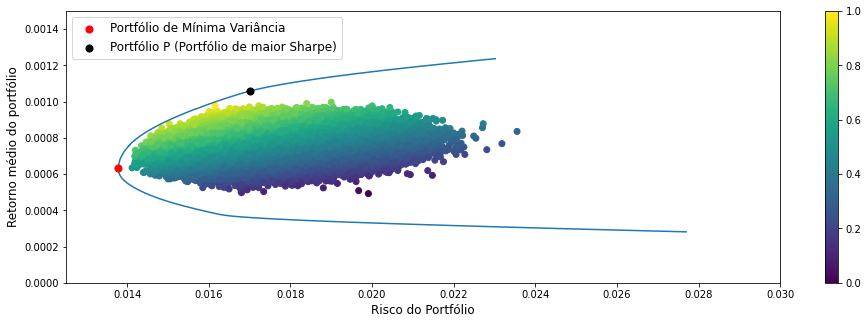

In [213]:
sharpe = (np.array(ret)-rf)/np.array(vol)
plt.figure(figsize=(16,5))
plt.scatter(vol,ret,c=sharpe,cmap="viridis")
plt.scatter(min_var,retorno_min_var,label="Portfólio de Mínima Variância",c="red",s=50,zorder=2)
plt.scatter(sharpe_max_vol,sharpe_max_retorno,label="Portfólio P (Portfólio de maior Sharpe)",c="black",s=50,zorder=2)
plt.plot(fronteira,retornos_vetor,zorder=1)
plt.xlabel("Risco do Portfólio",fontsize=12)
plt.ylabel("Retorno médio do portfólio",fontsize=12)
plt.axis([0.0125,0.03,0,0.0015])
plt.legend(loc="upper left",fontsize=12)
plt.colorbar()
plt.show()

### Plotando a fronteira com as simulações com o portfolio e a LAC:

In [199]:
#Inclinação da lac: 
inclinacao_lac = (sharpe_max_retorno-rf)/sharpe_max_vol

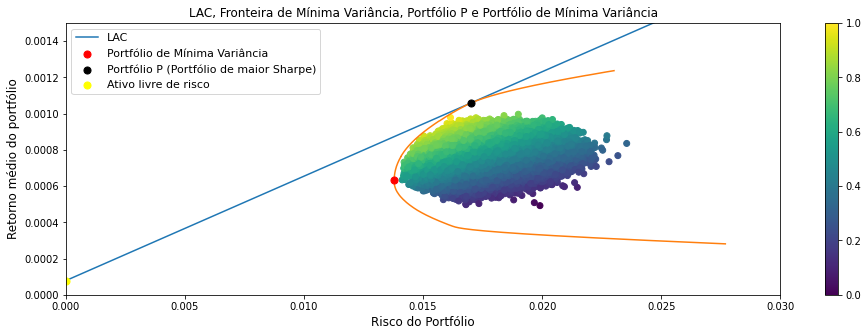

In [212]:
sharpe = (np.array(ret)-rf)/np.array(vol)
plt.figure(figsize=(16,5))
plt.scatter(vol,ret,c=sharpe,cmap="viridis")
plt.scatter(min_var,retorno_min_var,label="Portfólio de Mínima Variância",c="red",s=50,zorder=2)
plt.scatter(sharpe_max_vol,sharpe_max_retorno,label="Portfólio P (Portfólio de maior Sharpe)",c="black",s=50,zorder=2)
plt.scatter(0,rf,label="Ativo livre de risco",c="yellow",s=50,zorder=2)
plt.plot(np.array([0,0.01,0.02,0.03]),np.array([0,0.01,0.02,0.03])*inclinacao_lac+rf,label="LAC",zorder=1)
plt.plot(fronteira,retornos_vetor,zorder=1)
plt.xlabel("Risco do Portfólio",fontsize=12)
plt.ylabel("Retorno médio do portfólio",fontsize=12)
plt.axis([0,0.03,0,0.0015])
plt.legend(loc="upper left",fontsize=11)
plt.title("LAC, Fronteira de Mínima Variância, Portfólio P e Portfólio de Mínima Variância")
plt.colorbar()
plt.show()

### Pegando os pesos dos portfólios:

In [201]:
pesos_min_var = fronteira_pesos[fronteira.index(min_var)]
pesos_max_sharpe = fronteira_pesos[fronteira.index(sharpe_max_vol)]
df_portfolios = pd.DataFrame()
df_portfolios["Pesos Min Var"]=pesos_min_var
df_portfolios["Pesos Max Sharpe"]=pesos_max_sharpe
df_portfolios.index=media_retornos.index
df_portfolios.to_excel("portfolios min var + max sharpe APS FIN2.xlsx")

#### Retorno médio mensal do portfólio de sharpe máximo:

In [202]:
sharpe_max_retorno

0.0010590705968377676

#### Volatilidade anualizada do portfólio de sharpe máximo:

In [203]:
sharpe_max_vol*(12)**0.5

0.05895257291564283

#### Sharpe do portfólio de maior sharpe:

In [204]:
(sharpe_max_retorno-rf)/sharpe_max_vol

0.05761414256602933

#### Retorno médio mensal do portfólio de mínima variância:

In [205]:
retorno_min_var

0.0006354715076798262

#### Volatilidade anualizada do portfólio de mínima variância:

In [206]:
min_var*(12)**0.5

0.047744775427309274

#### Sharpe do portfólio de mínima variância:

In [207]:
(retorno_min_var-rf)/min_var

0.04040466489595752

### Montando carteiras compostas do portfólio de mercado/portfólio P e pela taxa livre de risco

In [208]:
df_perfis = pd.DataFrame()
df_perfis["Coeficiente de Aversão ao risco (A)"]=list(range(50,1000))
df_perfis

,Coeficiente de Aversão ao risco (A)
0,50
1,51
2,52
3,53
4,54
...,...
945,995
946,996
947,997
948,998


In [209]:
def alocacao(df):
    return (sharpe_max_retorno-rf)/((sharpe_max_vol**2)*df["Coeficiente de Aversão ao risco (A)"])

df_perfis["Alocação no Portfólio de Mercado/Portfólio P"] = df_perfis.apply(alocacao,axis=1)
df_perfis["Alocação na Taxa Livre de Risco"] = (df_perfis["Alocação no Portfólio de Mercado/Portfólio P"]*(-1)).add(1)
df_perfis

,Coeficiente de Aversão ao risco (A),Alocação no Portfólio de Mercado/Portfólio P,Alocação na Taxa Livre de Risco
0,50,0.067709,0.932291
1,51,0.066381,0.933619
2,52,0.065105,0.934895
3,53,0.063876,0.936124
4,54,0.062694,0.937306
...,...,...,...
945,995,0.003402,0.996598
946,996,0.003399,0.996601
947,997,0.003396,0.996604
948,998,0.003392,0.996608


### Plotando portfólios na LAC:

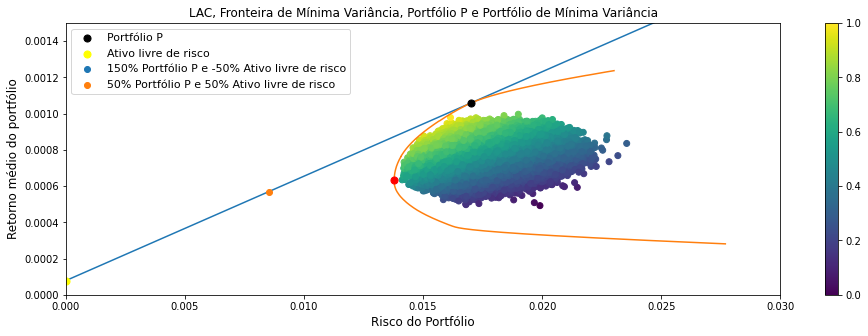

In [210]:
sharpe = (np.array(ret)-0)/np.array(vol)
plt.figure(figsize=(16,5))
plt.scatter(vol,ret,c=sharpe,cmap="viridis")
plt.scatter(min_var,retorno_min_var,c="red",s=50,zorder=2)
plt.scatter(sharpe_max_vol,sharpe_max_retorno,label="Portfólio P",c="black",s=50,zorder=2)
plt.scatter(0,rf,label="Ativo livre de risco",c="yellow",s=50,zorder=2)
plt.plot(np.array([0,0.01,0.02,0.03]),np.array([0,0.01,0.02,0.03])*inclinacao_lac+rf,zorder=1)
plt.scatter(1.5*sharpe_max_vol,1.5*sharpe_max_retorno-0.5*rf,zorder=2,label="150% Portfólio P e -50% Ativo livre de risco")
plt.scatter(0.5*sharpe_max_vol,0.5*sharpe_max_retorno+0.5*rf,zorder=2,label="50% Portfólio P e 50% Ativo livre de risco")
plt.plot(fronteira,retornos_vetor,zorder=1)
plt.xlabel("Risco do Portfólio",fontsize=12)
plt.ylabel("Retorno médio do portfólio",fontsize=12)
plt.axis([0,0.03,0,0.0015])
plt.legend(loc="upper left",fontsize=11)
plt.title("LAC, Fronteira de Mínima Variância, Portfólio P e Portfólio de Mínima Variância")
plt.colorbar()
plt.show()